.env:
  - defaults
dependencies:
  - nb_conda_kernels
  - pandas
  - scipy
  - plotly
  - psutil
  - nb_conda
  - requests
  - numpy
  - scikit-learn
  - python=3.7
  - plotly-orca
  - statsmodels
  - pip
  - pip:
    - gif==3.0.0
    - kaleido==0.2.1
    - pillow==8.1.2

# Utils

In [1]:
def get_statistics(y_pred, y_true, printing=True):
  precision_score = sklearn.metrics.precision_score(y_pred, y_true)
  accuracy_score = sklearn.metrics.accuracy_score(y_pred, y_true)
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_pred, y_true, pos_label=1)
  roc_auc = sklearn.metrics.auc(fpr, tpr)
  mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
  if printing:
    print(f"""Accuracy Score: {accuracy_score}
Precision Score: {precision_score}
MSE: {mse}
ROC_AUC: {roc_auc}""")
  return accuracy_score, precision_score, mse, roc_auc


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

def roc_curve(y_pred, y_true, pos_label=1, showing=True):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_pred, y_true, pos_label=pos_label)
  roc_auc = sklearn.metrics.auc(fpr, tpr)
  if not showing:
    return roc_auc
  display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='roc_curve')
  display.plot()
  plt.show()
  return roc_auc


In [3]:
import pandas as pd
def parse_cancellation_policy(row):
  policy, cost_per_night, total_cost = row["cancellation_policy_code"], row["original_selling_amount_usd"]/row["stay_length_days"], row["original_selling_amount_usd"]
  price_row = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=[-100,-80,-60,-40,-30,-20,-10,-5,-3,-1,0,1])
  rules = policy.split("_")
  if policy!="UNKNOWN":
    for rule in rules:
      days = 1
      if "D" in rule:
        days = -int(rule.split("D")[0])
        price = rule.split("D")[1]
      else:
        price=rule
      if "P" in price:
        price_usd = total_cost * int(price.replace("P", "")) / 100.0
      elif "N" in price:
        price_usd = cost_per_night * int(price.replace("N", ""))
      price_row.loc[price_row.index >= days] = price_usd
      # ret_val["cost"][ret_val["day"] >= days] = price_usd
  else:
    price_row.loc[:] = total_cost
  row = pd.concat([row, price_row.add_prefix("cancellation_price_").add_suffix("_days")])
  return row

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Setup

In [5]:
"""
The following file contains base classes for all estimators.
Class design and part of the code is taken and/or influenced
by the Python scikit-learn package, and specifically the
BaseEstimator.py file

# Author: Gilad Green <iml@mail.huji.ac.il>
# License: BSD 3 clause
"""
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import NoReturn
import numpy as np
import pandas as pd
import sklearn

class BaseEstimator(ABC):
    """
    Base class of supervised estimators (classifiers and regressors)
    """

    def __init__(self) -> BaseEstimator:
        """
        Initialize a supervised estimator instance

        Attributes
        ----------
        fitted_ : bool
            Indicates if estimator has been fitted. Set by ``self.fit`` function
        """
        self.fitted_ = False

    def fit(self, X: np.ndarray, y: np.ndarray) -> BaseEstimator:
        """
        Fit estimator for given input samples and responses

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to fit an estimator for
        y : ndarray of shape (n_samples, )
            Responses of input data to fit to

        Returns
        -------
        self : returns an instance of self.

        Notes
        -----
        After fitting sets ``self.fitted_`` attribute to `True`
        """
        self._fit(X, y)
        self.fitted_ = True
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict responses for given samples using fitted estimator

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to predict responses for

        Returns
        -------
        responses : ndarray of shape (n_samples, )
            Predicted responses of given samples

        Raises
        ------
        ValueError is raised if ``self.predict`` was called before calling ``self.fit``
        """
        if not self.fitted_:
            raise ValueError("Estimator must first be fitted before calling ``predict``")
        return self._predict(X)

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Evaluate performance under loss function specified for estimator

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Test samples

        y : ndarray of shape (n_samples, )
            True labels of test samples

        Returns
        -------
        loss : float
            Performance under loss function specified for estimator

        Raises
        ------
        ValueError is raised if ``self.loss`` was called before calling ``self.fit``
        """
        if not self.fitted_:
            raise ValueError("Estimator must first be fitted before calling ``loss``")
        return self._loss(X, y)

    @abstractmethod
    def _fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Fit estimator for given input samples and responses

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to fit an estimator for

        y : ndarray of shape (n_samples, )
            Responses of input data to fit to
        """
        raise NotImplementedError()

    @abstractmethod
    def _predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict responses for given samples using fitted estimator

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to predict responses for

        Returns
        -------
        responses : ndarray of shape (n_samples, )
            Predicted responses of given samples
        """
        raise NotImplementedError()

    @abstractmethod
    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Evaluate performance under loss function specified for estimator

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Test samples

        y : ndarray of shape (n_samples, )
            True labels of test samples

        Returns
        -------
        loss : float
            Performance under loss function specified for estimator
        """
        raise NotImplementedError()

    def fit_predict(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Fit an estimator over given input data and predict responses for given samples

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to fit an estimator for

        y : ndarray of shape (n_samples, )
            Responses of input data to fit to

        Returns
        -------
        responses : ndarray of shape (n_samples, )
            Predicted responses of given samples
        """
        self.fit(X, y)
        return self.predict(X)


# Model

In [6]:
from __future__ import annotations
from typing import NoReturn
import numpy as np
from sklearn import svm

class AgodaCancellationEstimator(BaseEstimator):
    """
    An estimator for solving the Agoda Cancellation challenge
    """

    def __init__(self):
        """
        Instantiate an estimator for solving the Agoda Cancellation challenge

        Parameters
        ----------


        Attributes
        ----------

        """
        super().__init__()
        self.clf = svm.SVC(gamma=0.01, C=1000.)

    def _fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Fit an estimator for given samples

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to fit an estimator for

        y : ndarray of shape (n_samples, )
            Responses of input data to fit to

        Notes
        -----

        """
        self.clf.fit(X,y)

    def _predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict responses for given samples using fitted estimator

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data to predict responses for

        Returns
        -------
        responses : ndarray of shape (n_samples, )
            Predicted responses of given samples
        """
        return self.clf.predict(X)

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Evaluate performance under loss function

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Test samples

        y : ndarray of shape (n_samples, )
            True labels of test samples

        Returns
        -------
        loss : float
            Performance under loss function
        """
        pass


# Data Preproccessing

In [7]:
dummy_dict = dict()

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import date
from datetime import datetime



def add_one_hot_encoding_of_column(features: pd.DataFrame, feature_name: str):
    column_dummies = pd.get_dummies(features[feature_name], prefix=feature_name).apply(pd.Series)
    if not feature_name in dummy_dict:
      dummy_dict[feature_name] = column_dummies.columns
    column_dummies = column_dummies.T.reindex(dummy_dict[feature_name]).T.fillna(0)
    return pd.concat([features.drop(columns=feature_name), column_dummies], axis=1)

DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"

def load_data(filename: str, classifier_mode=True):
    """
    Load Agoda booking cancellation dataset
    Parameters
    ----------
    filename: str
        Path to house prices dataset

    Returns
    -------
    Design matrix and response vector in either of the following formats:
    1) Single dataframe with last column representing the response
    2) Tuple of pandas.DataFrame and Series
    3) Tuple of ndarray of shape (n_samples, n_features) and ndarray of shape (n_samples,)
    """
    # TODO - replace below code with any desired preprocessing
    full_data = pd.read_csv(filename).drop_duplicates()

    # features = full_data[["h_booking_id",
    #                       "hotel_id",
    #                       "accommadation_type_name",
    #                       "hotel_star_rating",
    #                       "customer_nationality"]]
    if not classifier_mode:
      full_data = full_data.dropna()
    labels = full_data["cancellation_datetime"]
    features = full_data
    return features, labels
  

def pre_proccess_data(features, labels, classifier_mode=True):
    features = features.fillna(0)
    if "cancellation_datetime" in features:
      del features["cancellation_datetime"]
    del features["h_booking_id"]
    del features["hotel_id"]
    del features["h_customer_id"]
    # del features["customer_nationality"] # related to many other columns
    features = add_one_hot_encoding_of_column(features, "customer_nationality")
    del features["hotel_area_code"] # could be usful
    del features["hotel_brand_code"] # ^
    del features["hotel_chain_code"] # ^
    del features["hotel_city_code"] # ^
    del features["language"] # requires further analysis perhaps
    features = add_one_hot_encoding_of_column(features, "guest_nationality_country_name") # also could be useful
    features["is_first_booking"] = features["is_first_booking"].astype(float)
    features["is_user_logged_in"] = features["is_user_logged_in"].astype(float)
    features = add_one_hot_encoding_of_column(features, "original_payment_type")
    features = add_one_hot_encoding_of_column(features, "hotel_country_code")
    features = add_one_hot_encoding_of_column(features, "charge_option")
    features = add_one_hot_encoding_of_column(features, "original_payment_method")
    features = add_one_hot_encoding_of_column(features, "accommadation_type_name")
    features = add_one_hot_encoding_of_column(features, "origin_country_code")
    features["stay_length_days"] = (pd.to_datetime(features["checkout_date"]) - pd.to_datetime(features["checkin_date"])).dt.days
    features["booking_to_checkin_days"] = (pd.to_datetime(features["checkin_date"]) - pd.to_datetime(features["booking_datetime"])).dt.days
    features["booking_to_checkout_days"] = (pd.to_datetime(features["checkout_date"]) - pd.to_datetime(features["booking_datetime"])).dt.days
    features["hotel_live_year"] = (pd.to_datetime(features["booking_datetime"]) - pd.to_datetime(features["hotel_live_date"])).dt.days / 365
    # currency conversion to USD
    features['original_selling_amount_usd'] = features['original_selling_amount']
    del features['original_payment_currency']
    del features['original_selling_amount']
    # t = c.convert(100, 'USD', 'BGN', date=date(2010, 11, 21)) - possible to do according to timestamp

    my_labels = None

    # change labels to contain delta time checkin - cancelled
    if labels is not None:
      my_labels = (pd.to_datetime(features['checkin_date']) - pd.to_datetime(labels)).apply(lambda x: x.days)

    if classifier_mode and labels is not None:
      my_labels = my_labels.apply(lambda x: 1 if np.all(pd.notnull([x])) else 0)

    # can possibly turn into seconds amounts for mathimatical fitting
    features["order_hour"] = pd.to_datetime(features["booking_datetime"]).dt.hour
    del features["booking_datetime"]
    del features["checkin_date"]
    del features["checkout_date"]
    del features["hotel_live_date"]

    # cancellation_policy_code needs to be treated but removed for now
    features = features.apply(parse_cancellation_policy, axis=1)
    # features = features.apply(preprocess_policy, axis=1)
    del features["cancellation_policy_code"]

    return features, my_labels, labels

In [9]:
features_no_null, labels_no_null = load_data("/content/drive/MyDrive/data challenge/agoda_cancellation_train.csv", classifier_mode=False)
features_with_null, labels_with_null = load_data("/content/drive/MyDrive/data challenge/agoda_cancellation_train.csv", classifier_mode=True)

df_with_null, cancellation_labels_with_null, true_labels_with_null = pre_proccess_data(features_with_null, labels_with_null, classifier_mode=True)
df_no_null, cancellation_labels_no_null, true_labels_no_null = pre_proccess_data(features_no_null, labels_no_null, classifier_mode=False)

In [10]:
NULL_LABEL_AMOUNT = 0
fixed_labels = cancellation_labels_with_null.head(NULL_LABEL_AMOUNT)
fixed_labels = fixed_labels.where(fixed_labels == 0).dropna()
fixed_labels.apply(lambda x: 0)
df_small_null = df_no_null.append(df_with_null.head(NULL_LABEL_AMOUNT).where(fixed_labels == 0).dropna(), ignore_index = False)
cancellation_labels_small_null = cancellation_labels_no_null.append(fixed_labels, ignore_index = False)

# Classifier

## Fitting Classifier #1 (GradientBoostedClassifier) (using for classification but actually using threshold = 0 so not really using..)

In [43]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_with_null, cancellation_labels_with_null)

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
classifier = GradientBoostingClassifier(n_estimators=300, subsample=0.5, min_samples_leaf=1, learning_rate = 0.01, max_depth=3, verbose=1).fit(train_X, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1623           0.0052            1.56m
         2           1.1572           0.0051            1.56m
         3           1.1468           0.0049            1.55m
         4           1.1406           0.0048            1.56m
         5           1.1390           0.0047            1.55m
         6           1.1342           0.0046            1.54m
         7           1.1280           0.0045            1.53m
         8           1.1276           0.0044            1.52m
         9           1.1179           0.0044            1.52m
        10           1.1179           0.0043            1.51m
        20           1.0874           0.0035            1.45m
        30           1.0546           0.0029            1.39m
        40           1.0231           0.0024            1.34m
        50           1.0054           0.0018            1.29m
        60           0.9804           0.0018            1.23m
       

In [44]:
classifier.feature_importances_

classifier_coefs = pd.DataFrame(
   classifier.feature_importances_,
   columns=['Coefficients'], index=train_X.columns
)

In [45]:
classifier_coefs.sort_values(by="Coefficients", ascending=False).head(40)

,Coefficients
charge_option_Pay Now,0.397217
booking_to_checkout_days,0.190431
cancellation_price_-100_days,0.059148
booking_to_checkin_days,0.056600
original_payment_method_UNKNOWN,0.051135
cancellation_price_-80_days,0.044971
hotel_live_year,0.038862
cancellation_price_-20_days,0.035097
cancellation_price_-10_days,0.026146
cancellation_price_-60_days,0.011359


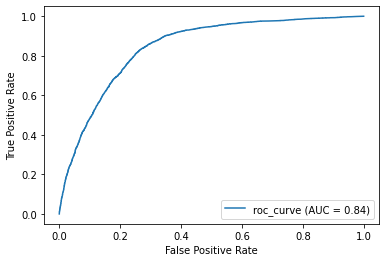

0.8435338521952321

In [46]:
roc_curve(test_y, classifier.predict_proba(test_X)[:, 1], pos_label=1)

In [47]:
get_statistics(test_y, classifier.predict(test_X) >= 0.5)

Accuracy Score: 0.7883395840436414
Precision Score: 0.6260677000949066
MSE: 0.21166041595635868
ROC_AUC: 0.6987476698225334


(0.7883395840436414,
 0.6260677000949066,
 0.21166041595635868,
 0.6987476698225334)

## Hyper Params #1 (GradientBoostedClassifier)

In [ ]:
max_depth = list(range(1,11))
accuracies = []
precisions = []
# from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
train_X, test_X, train_y , test_y = train_test_split(df_with_null, cancellation_labels_with_null)

for i in max_depth:
  print(f"Max Depth {i}")
  estimator = xgb.XGBRegressor(n_estimators=200, learning_rate = float(i)/10, max_depth=8, verbosity=2).fit(train_X, train_y)
  accuracy = sklearn.metrics.accuracy_score(estimator.predict(test_X), test_y)
  precision = sklearn.metrics.precision_score(estimator.predict(test_X), test_y)
  accuracies.append(accuracy)
  precisions.append(precision)

In [ ]:
import matplotlib.pyplot as plt

#accuracy
fig, ax = plt.subplots()
ax.plot(max_depth[:15], accuracies)

ax.set(xlabel='Max Depth', ylabel='Accuracy',
       title='Accuracy vs. Max Depth')
ax.grid()

plt.show()

# precision
fig, ax = plt.subplots()

ax.set(xlabel='Max Depth', ylabel='Precision',
       title='Precision vs. Max Depth')
ax.grid()

ax.plot(max_depth[:15], precisions)

plt.show()

## Fitting Classifier #2 (KNN)

In [ ]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_with_null, cancellation_labels_with_null)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
classifier = KNeighborsClassifier(n_neighbors=100, weights="distance").fit(train_X, train_y)

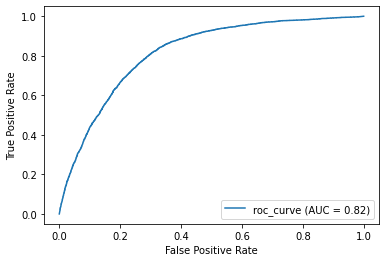

0.8172642775852098

In [ ]:
roc_curve(test_y, classifier.predict_proba(test_X)[:, 1], pos_label=1)

## Hyper-Params #2 (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

estimator = KNeighborsClassifier()

In [ ]:
estimator.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
param_grid={'n_neighbors': [5,20,50,100], 'weights': ['uniform', 'distance']}
clf = GridSearchCV(estimator, param_grid=param_grid, cv=3, verbose=3)
clf.fit(train_X, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END ....n_neighbors=5, weights=uniform;, score=0.758 total time=  30.9s
[CV 2/3] END ....n_neighbors=5, weights=uniform;, score=0.760 total time=  27.2s
[CV 3/3] END ....n_neighbors=5, weights=uniform;, score=0.754 total time=  26.1s
[CV 1/3] END ...n_neighbors=5, weights=distance;, score=0.759 total time=  25.4s
[CV 2/3] END ...n_neighbors=5, weights=distance;, score=0.760 total time=  29.8s
[CV 3/3] END ...n_neighbors=5, weights=distance;, score=0.755 total time=  30.7s
[CV 1/3] END ...n_neighbors=20, weights=uniform;, score=0.764 total time=  38.3s
[CV 2/3] END ...n_neighbors=20, weights=uniform;, score=0.766 total time=  35.9s
[CV 3/3] END ...n_neighbors=20, weights=uniform;, score=0.763 total time=  31.1s
[CV 1/3] END ..n_neighbors=20, weights=distance;, score=0.768 total time=  31.6s
[CV 2/3] END ..n_neighbors=20, weights=distance;, score=0.770 total time=  26.9s
[CV 3/3] END ..n_neighbors=20, weights=distance;,

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 20, 50, 100],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [ ]:
clf.best_score_

0.7725371866576863

In [ ]:
clf.best_params_

{'n_neighbors': 100, 'weights': 'distance'}

## Fitting Classifier #3 (Logistic Regression)

In [ ]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_with_null, cancellation_labels_with_null)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
classifier = LogisticRegression(C=0.5, max_iter=1000, verbose=1).fit(train_X, train_y)
# C == regularization strength (smaller = more regularization)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


In [ ]:
classifier_coefs = pd.DataFrame(
   classifier.coef_.T,
   columns=['Coefficients'], index=train_X.columns
)

In [ ]:
classifier_coefs.sort_values(by="Coefficients", ascending=False).head(40)

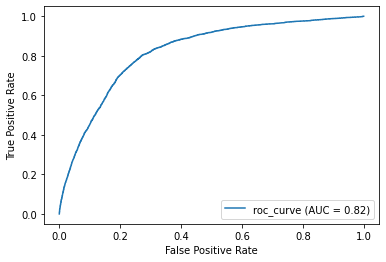

0.8221080674604299

In [ ]:
roc_curve(test_y, classifier.predict_proba(test_X)[:, 1], pos_label=1)

In [ ]:
get_statistics(test_y, classifier.predict(test_X) >= 0.5)

Accuracy Score: 0.7813842482100238
Precision Score: 0.6349514563106796
MSE: 0.21861575178997614
ROC_AUC: 0.6658975854555583


(0.7813842482100238,
 0.6349514563106796,
 0.21861575178997614,
 0.6658975854555583)

## Hyper-Params #3 (Logistic Regression)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

estimator = LogisticRegression()

In [ ]:
estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [ ]:
param_grid={'C': [5,2,1,0.5,0.1,0.05,0.01], 'penalty': ['l1', 'l2', 'elastic']}
clf = GridSearchCV(estimator, param_grid=param_grid, cv=3, verbose=3)
clf.fit(train_X, train_y)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3] END .....................C=5, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END .....................C=5, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END .....................C=5, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ...................C=5, penalty=l2;, score=0.766 total time=   7.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ...................C=5, penalty=l2;, score=0.766 total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END ...................C=5, penalty=l2;, score=0.767 total time=   5.3s
[CV 1/3] END ................C=5, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END ................C=5, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END ................C=5, penalty=elastic;, score=nan total time=   0.1s
[CV 1/3] END .....................C=2, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END .....................C=2, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END .....................C=2, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ...................C=2, penalty=l2;, score=0.764 total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ...................C=2, penalty=l2;, score=0.766 total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END ...................C=2, penalty=l2;, score=0.766 total time=   5.2s
[CV 1/3] END ................C=2, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END ................C=2, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END ................C=2, penalty=elastic;, score=nan total time=   0.1s
[CV 1/3] END .....................C=1, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END .....................C=1, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END .....................C=1, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ...................C=1, penalty=l2;, score=0.764 total time=   5.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ...................C=1, penalty=l2;, score=0.766 total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END ...................C=1, penalty=l2;, score=0.765 total time=   5.3s
[CV 1/3] END ................C=1, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END ................C=1, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END ................C=1, penalty=elastic;, score=nan total time=   0.1s
[CV 1/3] END ...................C=0.5, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END ...................C=0.5, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END ...................C=0.5, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END .................C=0.5, penalty=l2;, score=0.767 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END .................C=0.5, penalty=l2;, score=0.765 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END .................C=0.5, penalty=l2;, score=0.767 total time=   4.3s
[CV 1/3] END ..............C=0.5, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END ..............C=0.5, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END ..............C=0.5, penalty=elastic;, score=nan total time=   0.1s
[CV 1/3] END ...................C=0.1, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END ...................C=0.1, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END ...................C=0.1, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END .................C=0.1, penalty=l2;, score=0.764 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END .................C=0.1, penalty=l2;, score=0.766 total time=   4.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END .................C=0.1, penalty=l2;, score=0.766 total time=   5.0s
[CV 1/3] END ..............C=0.1, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END ..............C=0.1, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END ..............C=0.1, penalty=elastic;, score=nan total time=   0.1s
[CV 1/3] END ..................C=0.05, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END ..................C=0.05, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END ..................C=0.05, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ................C=0.05, penalty=l2;, score=0.765 total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ................C=0.05, penalty=l2;, score=0.766 total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END ................C=0.05, penalty=l2;, score=0.766 total time=   4.6s
[CV 1/3] END .............C=0.05, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END .............C=0.05, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END .............C=0.05, penalty=elastic;, score=nan total time=   0.1s
[CV 1/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.1s
[CV 2/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.1s
[CV 3/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ................C=0.01, penalty=l2;, score=0.764 total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ................C=0.01, penalty=l2;, score=0.766 total time=   4.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END ................C=0.01, penalty=l2;, score=0.766 total time=   4.2s
[CV 1/3] END .............C=0.01, penalty=elastic;, score=nan total time=   0.1s
[CV 2/3] END .............C=0.01, penalty=elastic;, score=nan total time=   0.1s
[CV 3/3] END .............C=0.01, penalty=elastic;, score=nan total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
42 fits failed out of a total of 63.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [5, 2, 1, 0.5, 0.1, 0.05, 0.01],
                         'penalty': ['l1', 'l2', 'elastic']},
             verbose=3)

In [ ]:
clf.best_score_

0.7664226989291733

In [ ]:
clf.best_params_

{'C': 0.5, 'penalty': 'l2'}

# Regressor

## Fitting Regressor #1 (GradientBoostedRegressor) (USING THIS MODEL ONLY)

In [63]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_small_null, cancellation_labels_small_null)

from sklearn.ensemble import GradientBoostingRegressor
# regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bynode=1, colsample_bytree=1, gamma=0,
#        importance_type='gain', learning_rate=0.1, max_delta_step=0,
#        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=None, subsample=1, verbosity=1).fit(train_X, train_y)
# regressor = xgb.XGBRegressor(n_estimators=200, learning_rate = 0.1, max_depth=3, verbosity=0).fit(train_X, train_y)
regressor = GradientBoostingRegressor(n_estimators=300, subsample=0.5, min_samples_leaf=1, learning_rate = 0.01, max_depth=3, verbose=1, criterion="squared_error").fit(train_X, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        2535.1042          37.5197            2.38s
         2        2753.6522          34.7051            2.26s
         3        2613.2250          34.6178            2.22s
         4        2614.3853          34.2359            2.29s
         5        2285.8141          39.4081            2.28s
         6        2498.3150          35.1232            2.25s
         7        2251.3747          33.9475            2.57s
         8        2565.4702          29.4832            2.55s
         9        2359.9308          29.8393            2.50s
        10        2050.0127          29.6940            2.46s
        20        2019.7256          23.1510            2.08s
        30        1822.2587          20.1001            1.93s
        40        1643.5801          15.5636            1.86s
        50        1238.6094          12.5230            1.76s
        60        1286.9799          11.2903            1.68s
       

In [70]:
err = sklearn.metrics.mean_squared_error(regressor.predict(test_X), test_y)
print(f"MSE: {err}\nsquared MSE: {np.sqrt(err)}")

MSE: 828.0265912436047
squared MSE: 28.775451190964926


In [65]:
regressor.feature_importances_

regressor_coefs = pd.DataFrame(
   regressor.feature_importances_,
   columns=['Coefficients'], index=train_X.columns
)

In [66]:
regressor_coefs.sort_values(by="Coefficients", ascending=False).head(40)

,Coefficients
booking_to_checkout_days,0.510218
booking_to_checkin_days,0.376370
cancellation_price_-3_days,0.017326
cancellation_price_1_days,0.010864
hotel_live_year,0.007660
customer_nationality_Malaysia,0.007218
original_selling_amount_usd,0.006500
guest_nationality_country_name_Malaysia,0.004099
order_hour,0.003582
origin_country_code_TH,0.003569


## Hyper-Params #1 (GradientBoostedRegressor)

In [ ]:
np.random.seed(0)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# .fit(train_X, train_y)
estimator = GradientBoostingRegressor()

In [ ]:
estimator.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
param_grid={'learning_rate': [0.1,0.01], 'max_depth':[3,4,6,8,9], 'min_samples_leaf':[1,5,10], "n_estimators":[100,200,300], "subsample":[0.5,1], "verbose":[0]}
clf = GridSearchCV(estimator, param_grid=param_grid, cv=2, verbose=3)
clf.fit(train_X, train_y)

In [ ]:
clf.best_score_

0.7044821101691023

In [ ]:
clf.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'n_estimators': 300,
 'subsample': 0.5,
 'verbose': 0}

In [ ]:
# from sklearn.externals import joblib

# joblib.dump(clf, 'model_file_name.pkl')

## Fitting Regressor #2 (KNN)

In [ ]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_small_null, cancellation_labels_small_null)

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=20, weights="distance").fit(train_X, train_y)

In [ ]:
err = sklearn.metrics.mean_squared_error(regressor.predict(test_X), test_y)
print(f"MSE: {err}\nsquared MSE: {np.sqrt(err)}")

MSE: 1627.9705522302252
squared MSE: 40.34811708407501


## Hyper-Params #2 (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
np.random.seed(0)

estimator = KNeighborsRegressor()

In [ ]:
estimator.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
param_grid={'n_neighbors': list(range(1,100)), 'weights': ['uniform', 'distance']}
clf = GridSearchCV(estimator, param_grid=param_grid, cv=4, verbose=3)
clf.fit(train_X, train_y)

In [ ]:
clf.best_score_

0.5597626151217254

In [ ]:
clf.best_params_

{'n_neighbors': 20, 'weights': 'distance'}

## Fitting Regressor #3 (MLPRegressor)

In [ ]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_small_null, cancellation_labels_small_null)

from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes=(1200,), activation="logistic", alpha=1, learning_rate="invscaling", learning_rate_init=0.001, max_iter=1000, n_iter_no_change=15, verbose=1).fit(train_X, train_y)

Iteration 1, loss = 1732.17449584
Iteration 2, loss = 1456.51923925
Iteration 3, loss = 1344.28836331
Iteration 4, loss = 1287.11954535
Iteration 5, loss = 1230.58635654
Iteration 6, loss = 1171.28951508
Iteration 7, loss = 1103.16291223
Iteration 8, loss = 1035.35344214
Iteration 9, loss = 966.57093848
Iteration 10, loss = 899.84714775
Iteration 11, loss = 841.47690136
Iteration 12, loss = 789.30191765
Iteration 13, loss = 743.33738482
Iteration 14, loss = 705.22342237
Iteration 15, loss = 670.22254564
Iteration 16, loss = 644.46941667
Iteration 17, loss = 617.88543278
Iteration 18, loss = 597.14135218
Iteration 19, loss = 577.70218962
Iteration 20, loss = 565.17423643
Iteration 21, loss = 551.80545791
Iteration 22, loss = 543.48732027
Iteration 23, loss = 537.26599449
Iteration 24, loss = 524.39175918
Iteration 25, loss = 517.71102128
Iteration 26, loss = 505.57732523
Iteration 27, loss = 493.30854562
Iteration 28, loss = 488.19816771
Iteration 29, loss = 479.36208573
Iteration 30, l

In [ ]:
err = sklearn.metrics.mean_squared_error(regressor.predict(test_X), test_y)
print(f"MSE: {err}\nsquared MSE: {np.sqrt(err)}")

MSE: 1125.592478515355
squared MSE: 33.54985064818255


## Hyper-Params #3 (MLPRegressor)

In [ ]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_small_null, cancellation_labels_small_null)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
estimator = MLPRegressor()

In [ ]:
estimator.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
param_grid={'hidden_layer_sizes':[(600,),(600,600)], 'activation':['logistic', 'relu'], 'alpha':[1,10,100],
            'max_iter': [500], 'learning_rate':['constant'],"verbose":[0]}
clf = GridSearchCV(estimator, param_grid=param_grid, cv=4, verbose=3)
clf.fit(train_X, train_y)

In [ ]:
clf.best_score_

0.6556752972728243

In [ ]:
clf.best_params_

{'activation': 'logistic',
 'alpha': 10,
 'hidden_layer_sizes': (600,),
 'learning_rate': 'constant',
 'max_iter': 500,
 'verbose': 0}

In [ ]:
# from sklearn.externals import joblib

# joblib.dump(clf, 'model_file_name.pkl')

In [ ]:
err = sklearn.metrics.mean_squared_error(clf.best_estimator_.predict(test_X), test_y)
print(f"MSE: {err}\nsquared MSE: {np.sqrt(err)}")

MSE: 1155.189897799926
squared MSE: 33.98808464447395


## Fitting Regressor #4 (HistGradientBoostingRegressor)

In [ ]:
np.random.seed(0)
train_X, test_X, train_y , test_y = train_test_split(df_small_null, cancellation_labels_small_null)

from sklearn.ensemble import HistGradientBoostingRegressor
# regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bynode=1, colsample_bytree=1, gamma=0,
#        importance_type='gain', learning_rate=0.1, max_delta_step=0,
#        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=None, subsample=1, verbosity=1).fit(train_X, train_y)
# regressor = xgb.XGBRegressor(n_estimators=200, learning_rate = 0.1, max_depth=3, verbosity=0).fit(train_X, train_y)
regressor = HistGradientBoostingRegressor(max_iter=1000, verbose=1, l2_regularization=0, learning_rate=0.005, min_samples_leaf=3).fit(train_X, train_y)

In [49]:
err = sklearn.metrics.mean_squared_error(regressor.predict(test_X), test_y)
print(f"MSE: {err}\nsquared MSE: {np.sqrt(err)}")

MSE: 1352.187876400762
squared MSE: 36.772107315202405


## Hyper-Params #4 (HistGradientBoostingRegressor)

In [16]:
np.random.seed(0)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# .fit(train_X, train_y)
estimator = HistGradientBoostingRegressor()

In [17]:
estimator.get_params().keys()

dict_keys(['categorical_features', 'early_stopping', 'l2_regularization', 'learning_rate', 'loss', 'max_bins', 'max_depth', 'max_iter', 'max_leaf_nodes', 'min_samples_leaf', 'monotonic_cst', 'n_iter_no_change', 'random_state', 'scoring', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
param_grid={"max_iter":[150,200,250], "verbose":[0], "l2_regularization":[0], "learning_rate":[0.01], "min_samples_leaf":[1,2,3,4]}
clf = GridSearchCV(estimator, param_grid=param_grid, cv=3, verbose=3)
clf.fit(train_X, train_y)

In [20]:
clf.best_score_

0.7062832219006939

In [21]:
clf.best_params_

{'l2_regularization': 0,
 'learning_rate': 0.01,
 'max_iter': 250,
 'min_samples_leaf': 1,
 'verbose': 0}

In [ ]:
clf.cv_results_

In [ ]:
# from sklearn.externals import joblib

# joblib.dump(clf, 'model_file_name.pkl')

# Output Setup

In [78]:
def evaluate_and_export(pred_y: np.ndarray, filename: str):
    """
    Export to specified file the prediction results of given estimator on given testset.

    File saved is in csv format with a single column named 'predicted_values' and n_samples rows containing
    predicted values.

    Parameters
    ----------
    estimator: BaseEstimator or any object implementing predict() method as in BaseEstimator (for example sklearn)
        Fitted estimator to use for prediction

    X: ndarray of shape (n_samples, n_features)
        Test design matrix to predict its responses

    filename:
        path to store file at

    """
    pd.DataFrame(pred_y, columns=["predicted_values"]).to_csv(filename, index=False)

In [79]:
from datetime import timedelta
def predict_on_test_data(classifier_model, regressor_model, test_data_x, amount_of_hours_to_accept_for_cancel, classifier_threshold):
  proccessed_test_data_x, _, _ = pre_proccess_data(test_data_x, None, classifier_mode=True)
  cancelled = classifier_model.predict_proba(proccessed_test_data_x)[:, 1] >= classifier_threshold # <-- IMPORTANT THRESHOLD FOR CLASSIFIER
  proccessed_test_data_no_null_x, _, _ = pre_proccess_data(test_data_x, None, classifier_mode=False)
  proccessed_test_data_only_cancelled = proccessed_test_data_no_null_x[cancelled]
  predicted_days_before_to_cancel = regressor_model.predict(proccessed_test_data_only_cancelled)
  time_deltas = np.array([timedelta(days=float(x)) for x in predicted_days_before_to_cancel])
  checkin_dates = test_data_x[cancelled]["checkin_date"]
  final_times = pd.to_datetime(checkin_dates) - time_deltas
  final_answer_no_non_cancels = (datetime(2018, 12, 10, 0, 0, 0) + timedelta(hours=amount_of_hours_to_accept_for_cancel) >= final_times) & (final_times >= datetime(2018, 12, 10, 0, 0, 0) - timedelta(hours=amount_of_hours_to_accept_for_cancel))
  final_answer_no_non_cancels = np.where(final_answer_no_non_cancels)
  final_answer = np.zeros(test_data_x.shape[0])
  final_answer[final_answer_no_non_cancels] = True
  return final_answer

In [80]:
def perform_entire_test(classifier_model, regressor_model, week_number, amount_of_hours_to_accept_for_cancel=72, classifier_threshold=0.0, printing=True):
  test_data_x = pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_test_data.csv")
  test_data_y = pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_labels.csv")
  y_test_predict = predict_on_test_data(classifier_model, regressor_model, test_data_x, amount_of_hours_to_accept_for_cancel, classifier_threshold)
  total_test = test_data_x.copy()
  total_test["label"] = test_data_y["cancel"]
  total_test["prediction"] = y_test_predict
  get_statistics(total_test["label"], total_test["prediction"], printing)
  confusion_matrix = sklearn.metrics.confusion_matrix(total_test["label"], total_test["prediction"])
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  if printing:
    disp.plot()
  auc = roc_curve(total_test["label"], total_test["prediction"], showing=printing)
  return auc, confusion_matrix

# Finding Best Time Threshold For Regressor

In [53]:
test_data_x_weeks = [pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_test_data.csv") for week_number in range(1,7)]
test_data_y_weeks = [pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_labels.csv") for week_number in range(1,7)]
total_test_data_x = pd.DataFrame().append(test_data_x_weeks, ignore_index=True)
total_test_data_y = pd.DataFrame().append(test_data_y_weeks, ignore_index=True)

In [ ]:
np.random.seed(0)
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

threshold_hours = list(range(1,72*4+1))
aucs = []
confusion_matrices = []
printing = False

test_data_x = total_test_data_x
test_data_y = total_test_data_y
total_test = test_data_x.copy()
proccessed_test_data_x, _, _ = pre_proccess_data(test_data_x, None, classifier_mode=True)
cancelled = classifier.predict_proba(proccessed_test_data_x)[:, 1] >= 0.0
proccessed_test_data_no_null_x, _, _ = pre_proccess_data(test_data_x, None, classifier_mode=False)
proccessed_test_data_only_cancelled = proccessed_test_data_no_null_x[cancelled]
predicted_days_before_to_cancel = regressor.predict(proccessed_test_data_only_cancelled)
time_deltas = np.array([timedelta(days=float(x)) for x in predicted_days_before_to_cancel])
checkin_dates = test_data_x[cancelled]["checkin_date"]
final_times = pd.to_datetime(checkin_dates) - time_deltas
for threshold in threshold_hours:
  final_answer_no_non_cancels = (datetime(2018, 12, 10, 0, 0, 0) + timedelta(hours=threshold) >= final_times) & (final_times >= datetime(2018, 12, 10, 0, 0, 0) - timedelta(hours=threshold))
  final_answer_no_non_cancels = np.where(final_answer_no_non_cancels)
  final_answer = np.zeros(test_data_x.shape[0])
  final_answer[final_answer_no_non_cancels] = True
  total_test["label"] = test_data_y["cancel"]
  total_test["prediction"] = final_answer
  get_statistics(total_test["label"], total_test["prediction"], printing)
  confusion_matrix = sklearn.metrics.confusion_matrix(total_test["label"], total_test["prediction"])
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  if printing:
    disp.plot()
  auc = roc_curve(total_test["label"], total_test["prediction"], showing=printing)

  print(f"{threshold} Hours, AUC: {auc}")
  aucs.append(auc)
  confusion_matrices.append(confusion_matrix)

In [ ]:
plt.plot(threshold_hours, aucs)

# Testing On Weeks

In [71]:
CLASSIFIER_THRESHOLD = 0.0
AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL = 150

Week 1

Accuracy Score: 0.6457142857142857
Precision Score: 0.04918032786885246
MSE: 0.35428571428571426
ROC_AUC: 0.5416666666666667


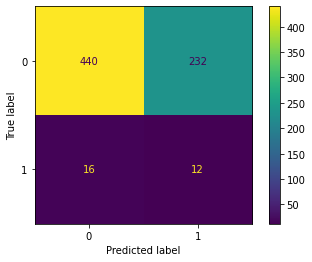

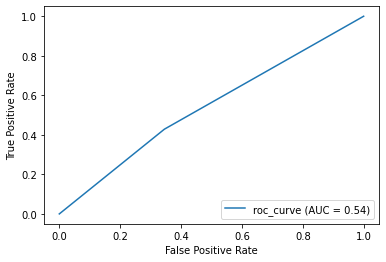

(0.5416666666666667, array([[440, 232],
        [ 16,  12]]))

In [72]:
perform_entire_test(classifier, regressor, 1, AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL, CLASSIFIER_THRESHOLD)

Week 2

Accuracy Score: 0.6614285714285715
Precision Score: 0.0379746835443038
MSE: 0.3385714285714286
ROC_AUC: 0.5828445747800587


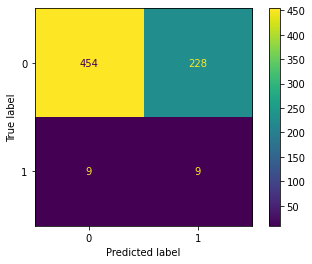

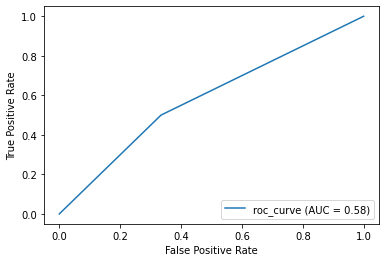

(0.5828445747800587, array([[454, 228],
        [  9,   9]]))

In [73]:
perform_entire_test(classifier, regressor, 2, AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL, CLASSIFIER_THRESHOLD)

Week 3

Accuracy Score: 0.6371428571428571
Precision Score: 0.05019305019305019
MSE: 0.3628571428571429
ROC_AUC: 0.6283750613647521


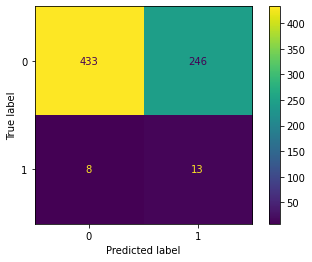

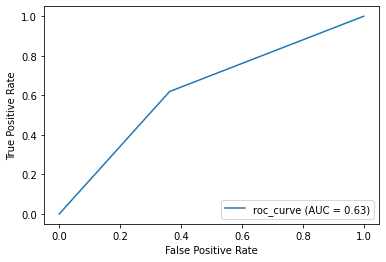

(0.6283750613647521, array([[433, 246],
        [  8,  13]]))

In [74]:
perform_entire_test(classifier, regressor, 3, AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL, CLASSIFIER_THRESHOLD)

Week 4

Accuracy Score: 0.6157142857142858
Precision Score: 0.022222222222222223
MSE: 0.3842857142857143
ROC_AUC: 0.5811452698245151


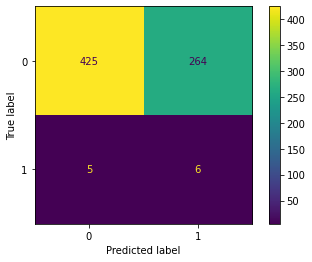

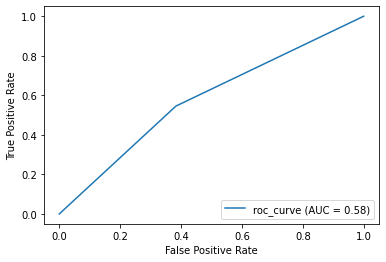

(0.5811452698245151, array([[425, 264],
        [  5,   6]]))

In [75]:
perform_entire_test(classifier, regressor, 4, AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL, CLASSIFIER_THRESHOLD)

Week 5

Accuracy Score: 0.6557142857142857
Precision Score: 0.034482758620689655
MSE: 0.3442857142857143
ROC_AUC: 0.4940740740740741


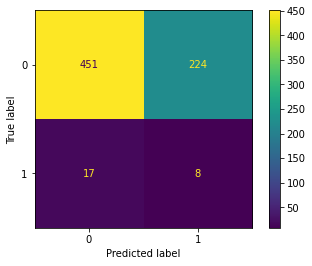

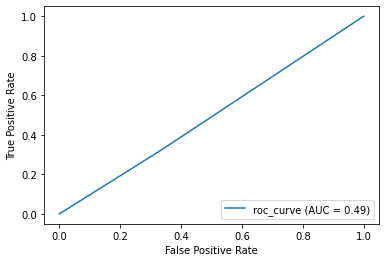

(0.4940740740740741, array([[451, 224],
        [ 17,   8]]))

In [76]:
perform_entire_test(classifier, regressor, 5, AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL, CLASSIFIER_THRESHOLD)

Week 6

Accuracy Score: 0.6342857142857142
Precision Score: 0.056
MSE: 0.3657142857142857
ROC_AUC: 0.5287051757639992


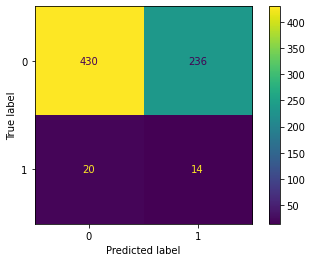

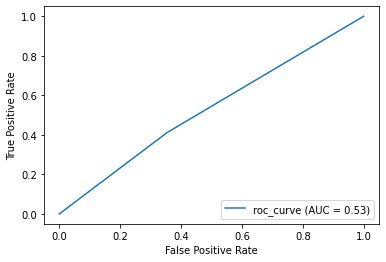

(0.5287051757639992, array([[430, 236],
        [ 20,  14]]))

In [77]:
perform_entire_test(classifier, regressor, 6, AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL, CLASSIFIER_THRESHOLD)

# Testing On All Test Data

In [81]:
CLASSIFIER_THRESHOLD = 0.0
AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL = 150

In [84]:
def test_all_data(classifier_thershold=CLASSIFIER_THRESHOLD, amount_of_hours_to_accept_for_cancel=AMOUNT_OF_HOURS_TO_ACCEPT_FOR_CANCEL):
  print(f"~~~ Classifier Threshold: {classifier_thershold} ~~~\n~~~ Hour Threshold: {amount_of_hours_to_accept_for_cancel} ~~~")
  test_data_x_weeks = [pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_test_data.csv") for week_number in range(1,7)]
  test_data_y_weeks = [pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_labels.csv") for week_number in range(1,7)]
  total_test_data_x = pd.DataFrame().append(test_data_x_weeks, ignore_index=True)
  total_test_data_y = pd.DataFrame().append(test_data_y_weeks, ignore_index=True)
  printing = True
  test_data_x = total_test_data_x
  test_data_y = total_test_data_y
  y_test_predict = predict_on_test_data(classifier, regressor, test_data_x, amount_of_hours_to_accept_for_cancel, classifier_thershold)
  total_test = test_data_x.copy()
  total_test["label"] = test_data_y["cancel"]
  total_test["prediction"] = y_test_predict
  get_statistics(total_test["label"], total_test["prediction"], printing)
  confusion_matrix = sklearn.metrics.confusion_matrix(total_test["label"], total_test["prediction"])
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  if printing:
    disp.plot()
  auc = roc_curve(total_test["label"], total_test["prediction"], showing=printing)
  return auc

~~~ Classifier Threshold: 0 ~~~
~~~ Hour Threshold: 160 ~~~
Accuracy Score: 0.6180952380952381
Precision Score: 0.040701314965560426
MSE: 0.3819047619047619
ROC_AUC: 0.5486956349897868


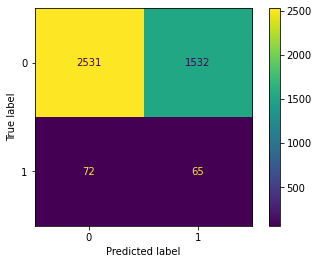

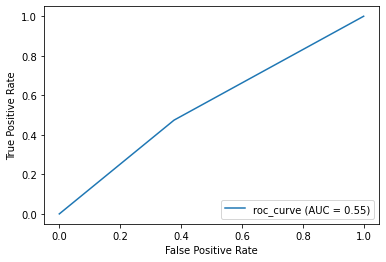

In [85]:
import itertools
class_thresholds = [0]
hour_thresholds = [160]
results = np.ndarray((len(class_thresholds), len(hour_thresholds)))
for class_thresh, hour_thresh in list(itertools.product(class_thresholds, hour_thresholds)):
  result = test_all_data(class_thresh, hour_thresh)
  results[class_thresholds.index(class_thresh),hour_thresholds.index(hour_thresh)] = result

In [86]:
results

array([[0.54869563]])

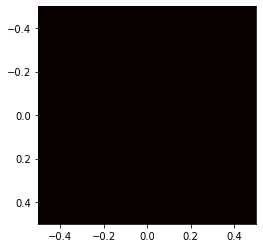

In [69]:
import matplotlib.pyplot as plt

plt.imshow(results, cmap='hot', interpolation='nearest')
plt.show()

# Outputing Results

In [ ]:
# for checking answers
# test_data_y = pd.read_csv("/content/drive/MyDrive/data challenge/week_7_labels.csv")
# final_answer = pd.read_csv("/content/drive/MyDrive/data challenge/abc.csv")

In [90]:
test_data_x_weeks = [pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_test_data.csv") for week_number in range(1,7)]
# test_data_y_weeks = [pd.read_csv(f"/content/drive/MyDrive/data challenge/week_{week_number}_labels.csv") for week_number in range(1,7)]
total_test_data_x = pd.DataFrame().append(test_data_x_weeks, ignore_index=True)
total_test_data_y = pd.DataFrame().append(test_data_y_weeks, ignore_index=True)
printing = True
test_data_x = total_test_data_x
test_data_y = total_test_data_y
y_test_predict = predict_on_test_data(classifier, regressor, test_data_x, 160, 0)
total_test = test_data_x.copy()
total_test["label"] = test_data_y["cancel"]
total_test["prediction"] = y_test_predict

In [95]:
y_test_predict[0:5]

array([1., 0., 0., 0., 1.])

In [94]:
evaluate_and_export(y_test_predict, "212554026_212362628_212722441.csv")